## 1. Load modules

In [1]:
import dolfin as dl
import ufl
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../hippylib1") )
from hippylib import *

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

np.random.seed(seed=1)

## 2. Set up the mesh and finite element spaces

We compute a two dimensional mesh of a unit square with nx by ny elements.
We define a P2 finite element space for the *state* and *adjoint* variable and P1 for the *parameter*.

In [2]:
ndim = 2
nx = 64
ny = 64
mesh = dl.UnitSquareMesh(nx, ny)
Vh2 = dl.FunctionSpace(mesh, 'Lagrange', 2)
Vh1 = dl.FunctionSpace(mesh, 'Lagrange', 1)
Vh = [Vh2, Vh1, Vh2]
print( "Number of dofs: STATE={0}, PARAMETER={1}, ADJOINT={2}".format(
    Vh[STATE].dim(), Vh[PARAMETER].dim(), Vh[ADJOINT].dim()) )

Number of dofs: STATE=16641, PARAMETER=4225, ADJOINT=16641


## 3. Set up the forward problem

To set up the forward problem we use the `PDEVariationalProblem` class, which requires the following inputs
- the finite element spaces for the state, parameter, and adjoint variables `Vh`
- the pde in weak form `pde_varf`
- the boundary conditions `bc` for the forward problem and `bc0` for the adjoint and incremental problems.

The `PDEVariationalProblem` class offer the following functionality:
- solving the forward/adjoint and incremental problems
- evaluate first and second partial derivative of the forward problem with respect to the state, parameter, and adojnt variables.

In [3]:
def u_boundary(x, on_boundary):
    return on_boundary and ( x[1] < dl.DOLFIN_EPS or x[1] > 1.0 - dl.DOLFIN_EPS)

def u_boundary2(x, on_boundary):
    return on_boundary and (x[0] < dl.DOLFIN_EPS or x[0] > 1.0 - dl.DOLFIN_EPS)

u_bdr  = dl.Expression("x[1]", degree=1)
u_bdr0 = dl.Constant(0.0)
bc =  [dl.DirichletBC(Vh[STATE], u_bdr, u_boundary), dl.DirichletBC(Vh[STATE], u_bdr, u_boundary2)]
bc0 = [dl.DirichletBC(Vh[STATE], u_bdr0, u_boundary), dl.DirichletBC(Vh[STATE], u_bdr0, u_boundary2)]

f = dl.Constant(1.0)
    
def pde_varf(u,m,p):
    return ufl.exp(m)*ufl.inner(ufl.grad(u), ufl.grad(p))*ufl.dx - f*p*ufl.dx
    
pde = PDEVariationalProblem(Vh, pde_varf, bc, bc0, is_fwd_linear=True)

## 4. Set up the prior regularization

Choose the ground truth and an averaged version for the prior mean, which will both help
define the prior regularization as well as provide an initialization for the Newton
optimization.



Prior regularization: (delta_x - gamma*Laplacian)^order: delta=0.001, gamma=0.1, order=1


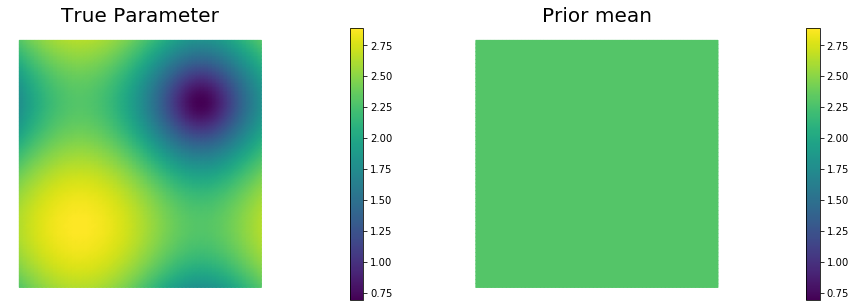

In [4]:
mtrue_field = dl.Expression('std::log(10. + 4.*std::sin(x[0]*2.*pi)+4.*std::sin(x[1]*2.*pi))',\
                        element = Vh[PARAMETER].ufl_element())

mtrue = dl.interpolate(mtrue_field, Vh[PARAMETER]).vector()

prior_mean = dl.interpolate(\
             dl.Expression('std::log(10.)', element=Vh[PARAMETER].ufl_element()),\
                            Vh[PARAMETER]).vector()

gamma = 1.e-1
delta = 1.e-3    
prior = LaplacianPrior(Vh[PARAMETER], gamma, delta, mean=prior_mean)

          
print("Prior regularization: (delta_x - gamma*Laplacian)^order: delta={0}, gamma={1}, order={2}".format(delta, gamma,1))    
            
objs = [dl.Function(Vh[PARAMETER],mtrue), dl.Function(Vh[PARAMETER],prior.mean)]
mytitles = ["True Parameter", "Prior mean"]
nb.multi1_plot(objs, mytitles)
plt.show()

## 5. Set up the misfit functional and generate synthetic observations

To setup the observation operator $\mathcal{B}: \mathcal{V} \mapsto \mathbb{R}^{n_t}$, we generate $n_t$ (`ntargets` in the code below) random locations where to evaluate the value of the state.

Under the assumption of Gaussian additive noise, the likelihood function $\pi_{\rm like}$ has the form

$$\pi_{\rm like}( \data \,| \, m ) \propto \exp\left( -\frac{1}{2}\|\mathcal{B}\,u(m) - \data \|^2_{\Gamma_{\rm noise}^{-1}}\right), $$

where $u(m)$ denotes the solution of the forward model at a given parameter $m$.

The class `PointwiseStateObservation` implements the evaluation of the log-likelihood function and of its partial derivatives w.r.t. the state $u$ and parameter $m$.

To generate the synthetic observation, we first solve the forward problem using the true parameter $m_{\rm true}$. Synthetic observations are obtained by perturbing the state variable at the observation points with a random Gaussian noise.
`rel_noise` is the signal to noise ratio.

Number of observation points: 100


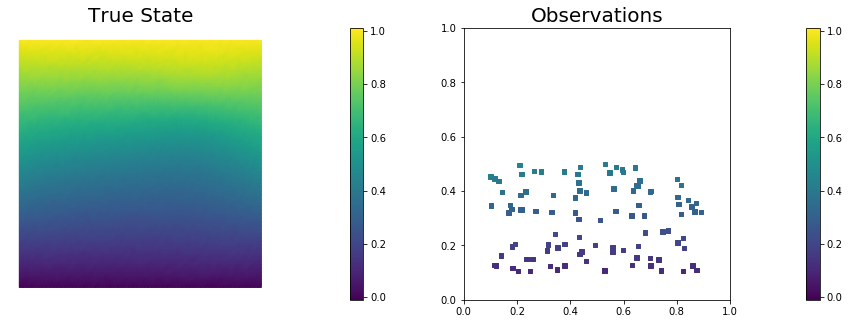

In [5]:
ntargets = 100
rel_noise = 0.01

#Targets only on the bottom
targets_x = np.random.uniform(0.1,0.9, [ntargets] )
targets_y = np.random.uniform(0.1,0.5, [ntargets] )
targets = np.zeros([ntargets, ndim])
targets[:,0] = targets_x
targets[:,1] = targets_y
#targets everywhere
#targets = np.random.uniform(0.1,0.9, [ntargets, ndim] )
print( "Number of observation points: {0}".format(ntargets) )
misfit = PointwiseStateObservation(Vh[STATE], targets)

#misfit = ContinuousStateObservation(Vh[STATE], dl.dx, bc)

utrue = pde.generate_state()
x = [utrue, mtrue, None]
pde.solveFwd(x[STATE], x)
misfit.B.mult(x[STATE], misfit.d)
MAX = misfit.d.norm("linf")
noise_std_dev = rel_noise * MAX
#noise_std_dev = 0.01
parRandom.normal_perturb(noise_std_dev, x[STATE])
misfit.noise_variance = noise_std_dev*noise_std_dev

vmax = max( utrue.max(), misfit.d.max() )
vmin = min( utrue.min(), misfit.d.min() )

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[STATE], utrue), mytitle="True State", subplot_loc=121, vmin=vmin, vmax=vmax)
nb.plot_pts(targets, misfit.d, mytitle="Observations", subplot_loc=122, vmin=vmin, vmax=vmax)
plt.show()

## 6. Set up the model and test gradient and Hessian

The model is defined by three component:
- the `PDEVariationalProblem` `pde` which provides methods for the solution of the forward problem, adjoint problem, and incremental forward and adjoint problems.
- the `Prior` `prior` which provides methods to apply the regularization (*precision*) operator to a vector or to apply the prior covariance operator (i.e. to solve linear system with the regularization operator)
- the `Misfit` `misfit` which provides methods to compute the cost functional and its partial derivatives with respect to the state and parameter variables.

To test gradient and the Hessian of the model we use forward finite differences.

(yy, H xx) - (xx, H yy) =  3.89306187859702e-16


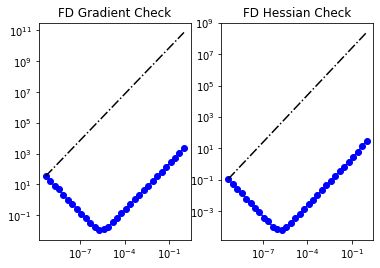

In [6]:
model = Model(pde, prior, misfit)

m0 = dl.interpolate(dl.Expression("sin(x[0])", degree=5), Vh[PARAMETER])
_ = modelVerify(model, m0.vector())

## 7. Compute the MAP point

We used the globalized Newtown-CG method to compute the MAP point.


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    1.077396e+03    1.077380e+03    1.560311e-02   -9.350966e+03   5.140689e+04   1.000000e+00   5.000000e-01
  2   1    5.102776e+02    5.102464e+02    3.115137e-02   -1.125766e+03   1.890582e+04   1.000000e+00   5.000000e-01
  3   2    2.691946e+01    2.684090e+01    7.855901e-02   -9.683720e+02   1.031309e+04   1.000000e+00   4.479026e-01
  4   3    6.808890e+00    6.717155e+00    9.173524e-02   -3.953171e+01   1.635709e+03   1.000000e+00   1.783785e-01
  5   6    5.286465e-01    4.208900e-01    1.077565e-01   -1.258427e+01   6.018958e+02   1.000000e+00   1.082057e-01
  6  19    1.225031e-01    7.181205e-03    1.153219e-01   -8.047356e-01   1.084721e+02   1.000000e+00   4.593549e-02
  7  26    1.172369e-01    1.839918e-03    1.153970e-01   -1.181324e-02   1.123115e+01   1.000000e+00   1.478092e-02
  8   1    1.159958e-01    5.728105e-04    1.154230e-01   -2.

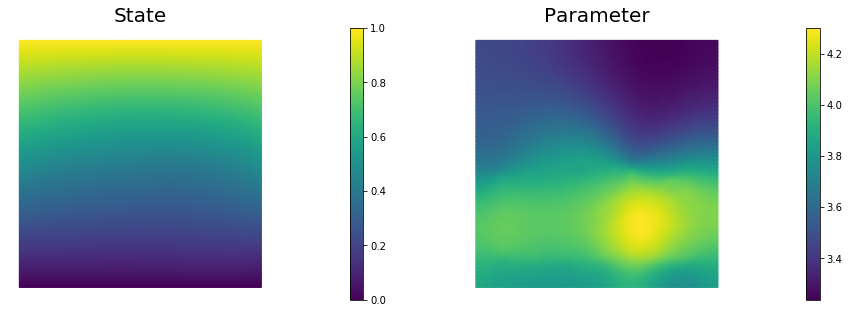

In [7]:
m = prior.mean.copy()
solver = ReducedSpaceNewtonCG(model)
solver.parameters["rel_tolerance"] = 1e-8
solver.parameters["abs_tolerance"] = 1e-12
solver.parameters["max_iter"]      = 25
solver.parameters["GN_iter"]       = 3
solver.parameters["globalization"] = "LS"
solver.parameters["LS"]["c_armijo"] = 1e-4

    
x = solver.solve([None, m, None])
    
if solver.converged:
    print( "\nConverged in ", solver.it, " iterations.")
else:
    print( "\nNot Converged")

print( "Termination reason: ", solver.termination_reasons[solver.reason] )
print( "Final gradient norm: ", solver.final_grad_norm )
print( "Final cost: ", solver.final_cost )

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[STATE], x[STATE]), subplot_loc=121,mytitle="State")
nb.plot(dl.Function(Vh[PARAMETER], x[PARAMETER]), subplot_loc=122,mytitle="Parameter")
plt.show()

## 8. Compute the Hessian action on a point source

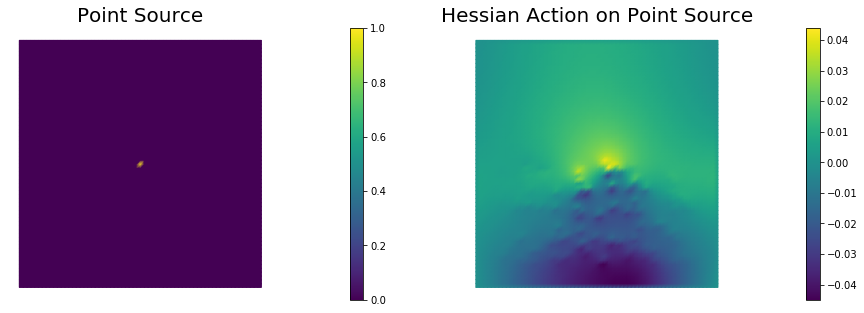

In [8]:
# ==== evaluate the model at the MAP point
model.setPointForHessianEvaluations(x, gauss_newton_approx=True)

# ==== construct a ReducedHessian object
Hmisfit = ReducedHessian(model, misfit_only=True)

# ==== set up PETSc vectors, in order to specify
#      what will be applied to the Hessian and
#      store the Hessian action
vecx = dl.Vector()
vecy = dl.Vector()
Hmisfit.init_vector(vecx, 1)
Hmisfit.init_vector(vecy, 0)

# ==== create a pointsource object and apply it
#      to the Hessian misfit
ps = dl.PointSource(Vh[PARAMETER], dl.Point(0.5,0.5),1)
ps.apply(vecx)
Hmisfit.mult(vecx, vecy)

# ==== display the results
objs = [dl.Function(Vh[PARAMETER], vecx), dl.Function(Vh[PARAMETER], vecy)]
mytitles = ["Point Source", "Hessian Action on Point Source"]
nb.multi1_plot(objs, mytitles, same_colorbar=False)
plt.show()